# Global Mean Sea Level (GMSL) Forecasting Using ARIMA

By:

**CRUEL, Nathaniel (2018-05737)**

**QUIRIM, Coleen (2018-05907)**

**SUMABAT, Carlo (2018-03037)**

**VIRTUCIO, Renzo (2018-03052)**

### DATA SOURCE 

The data source for this project is the spreadsheet file *CSIRO_Recons_gmsl_yr_2019.csv*, which can be downloaded in the page of the article  <a href="https://www.cmar.csiro.au/sealevel/sl_hist_few_hundred.html" target="_blank">**“Historical Sea Level Changes”**</a> of the old CSIRO website. The exact download link is <a href="ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv." target="_blank">*ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv.*</a>

CSIRO stands for the Commonwealth Scientific and Industrial Research Organisation, a government agency in Australia that conducts scientific research. The spreedsheet file documents the **Global Mean Sea Level (GMSL)** in millimeters (mm) and the **GMSL uncertainty** in mm from **1880 to 2019**.


### DATA PROCESSING

Part of our data preprocessing is dropping the *GMSL uncertainty (mm)* column since we will be merely focusing on the values in the column **GMSL/Global Mean Sea Level in millimeters (mm)** from 1880 to 2019 in our project. We will ONLY be using these proper GMSL values for our predictions, so we disregard the uncertainty values.

Additionally, we also reformatted the values in the **Year** column by removing the fractional part **.5** at the end of the values under the Year column. Thus, 1880.5 was turned to 1880, 1881.5 to 1881, and so on and so forth. This is so we can better represent the exact years that the GMSL values were gathered from. 

In reading the comma-separated spreadsheet (csv) file into dataframe **df**, we also set the **Year** column as the **index values** for our dataframe by setting ***index_col*** to 0 (pertaining to our 0th column, Year). This makes our data of measurements **indexed according to time, or in our case, according to the year**. Indexing our data set by the year makes time series analyis easier later.

We also check if our dataset has **missing values** by using the *isNa().sum()* function so we can perform data cleaning accordingly. The result of the function is shown below, which is 0, implying that we have **NO missing values** in our dataset. Thus, no data cleaning is needed.

Later on, in the **Exploratory Data Analysis section**, we check if our time series data is stationary or not. If our data is found to be non-stationary, then we conduct another data preprocessing procedure called **differencing** to make our data stationary and thus more suitable for our forecasting model. We conduct differencing as many times as necessary to produce a stationary time series data.


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("CSIRO_Recons_gmsl_yr_2019.csv", header=0, index_col=0)
df.drop(columns=["GMSL uncertainty (mm)"], axis=1, inplace=True)
df.index.names = ['Year']
df.rename(columns={"GMSL (mm)": "sea_level"}, inplace=True)

df.index = np.floor(df.index).astype(int)

print("Total null values\n", df.isna().sum())
df.head()

Total null values
 sea_level    0
dtype: int64


,sea_level
Year,
1880,-30.3
1881,-24.7
1882,-41.5
1883,-36.2
1884,-15.3


### EXPLORATORY DATA ANALYSIS

**ADF Test**

First, we check if our data (time series) is **stationary or non-stationary**. A **stationary time series has NO trend** and its **mean and variance are constant over time**. It is easier to predict when our time series is stationary. Models built on stationary data are generally more robust.

We want our time series variables to be **stationary** so the statistical properties of the model to be used **will NOT vary** depending on when the sample was taken. 

We use the **Augmented Dickey Fuller test (ADF test)** to check if our data is stationary or non-stationary. If **p value < 0.05**, our data is stationary and no differencing is needed. If **p value > 0.05**, then our data is non-stationary and we find a suitable order of differencing.  **Differencing** is only conducted on a non-stationary time series to make it stationary.

In [2]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df["sea_level"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.393374
p-value: 0.999007


c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


**Finding a suitable order of differencing**

Since our computed **p-value = 0.999007 > 0.05**, we identify an order of differencing such that the plot of the differenced data is stationary. We observe that the plot of the original series shows an **upward trend**, implying that the values **increase** over time. This means our time series data is NOT stationary. This supports our ADF test earlier which showed that our time series is non-stationary.

We observe that the plot of the **first and second order differencing** appear to be **stationary** compared to the original series. We thus choose the order differencing to be **2**. 

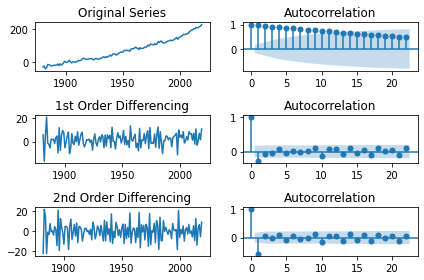

In [3]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df["sea_level"]); axes[0, 0].set_title('Original Series')
plot_acf(df["sea_level"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["sea_level"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["sea_level"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["sea_level"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout()
plt.show()

**Find the order of the AR term (p)**

We identify a possible order of the AR term by observing the partial autocorrelation plot of the second order differencing. We observe that the PACF lag 1 is quite significant since it is well below the significance line (past the blue shaded area). We take the order of the AR term to be 1.

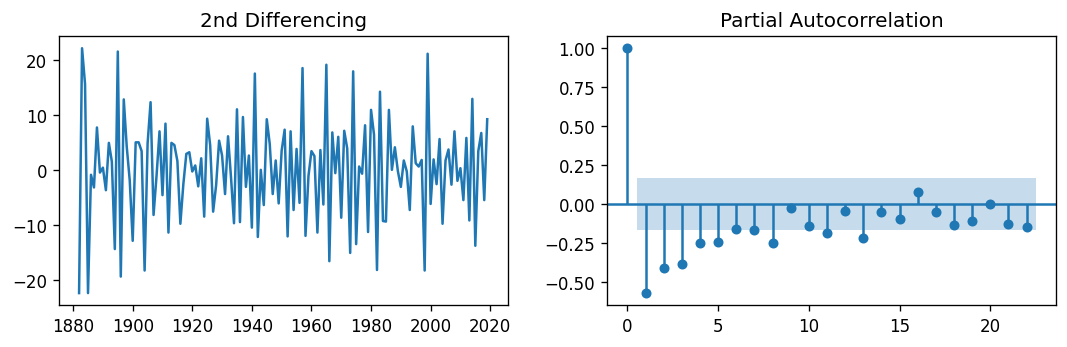

In [4]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
# axes[0].set_xlim([1880, 2019])
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('2nd Differencing')
plot_pacf(df["sea_level"].diff().diff().dropna(), ax=axes[1])

fig.tight_layout()
plt.show()

**Finding the order of the MA term (q)**

We identify a possible order of the MA term by observing the autocorrelation plot of the second order differencing. We observe that the ACF lag 1 is quite significant since it is well below the significance line (past the blue shaded area). We take the order of the MA term to be 1.

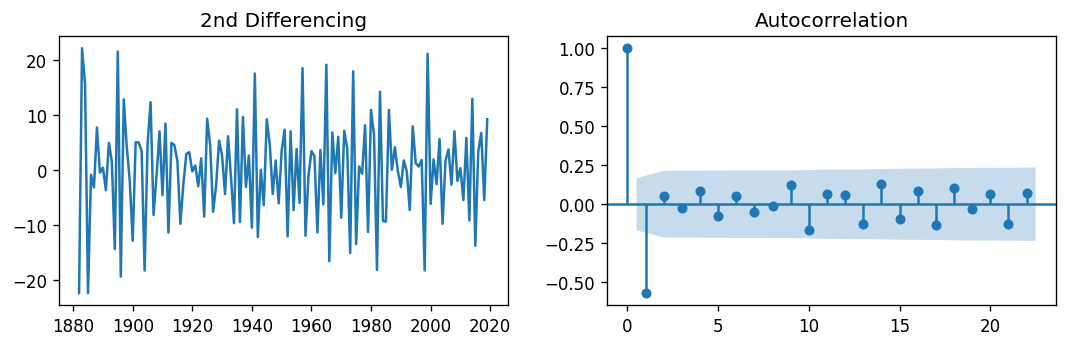

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('2nd Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[1])
fig.tight_layout()
plt.show()

### MODELLING

In this project, we will use the **ARIMA** model in our time series forecasting. ARIMA stands for **Auto Regressive Integrated Moving Average** and is a model that utilizes past values in a time series data to forecast future values. This model is suitable for our data since our data is a collection of (sea level) measurements gathered at **regular, equally spaced intervals of time - every year**.

ARIMA is divided into 3 parts - **AR (p), I (d), and MA (q)**. 

**AR (p)** is the **autoregressive part**. The **p** parameter is an integer that determines the **number of time periods or lagged series to be used** to forecast values in the time periods ahead.

**I (d)** is the **differencing part**. The **d** parameter is an integer that determines the **number of differencing transformations** to be applied to make the time series stationary (if it is nonstationary).

**MA (q)** is the **moving average** model. The **q** parameter is the **number of lagged forecast errors** that should be considered in the ARIMA model.

-----------------
Based on our exploratory data analysis (EDA) earlier, we set **2** as the **order of differencing (d)**, **1** as the **order of the AR term (p**), and **1** as the **order of the MA term (q)**. 

We now use these values to build our ARIMA model.

In [6]:
from statsmodels.tsa.arima.model import ARIMA
# prepare training dataset
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
arima_model = None
predictions = list()
for t in range(len(test)):
    arima_model = ARIMA(history, order=(1,2,1))
    arima_model_fit = arima_model.fit()
    yhat = arima_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

### RESULTS AND DISCUSSION

**Plotting the residuals**

We create a residual plot and a kernel density estimate plot from the residuals obtained as we forecasted using our ARIMA model. Note that a residual is the actual value subtracted by the forecasted or predicted value. We observe from the residual plot that the residuals are scattered randomly around the residual=0 line (y=0). On the other hand, we observe that the kernel distribution estimate plot has a near-zero mean and a low standard deviation. These plots indicate that the forecasts made by our ARIMA model are close to the actual data.

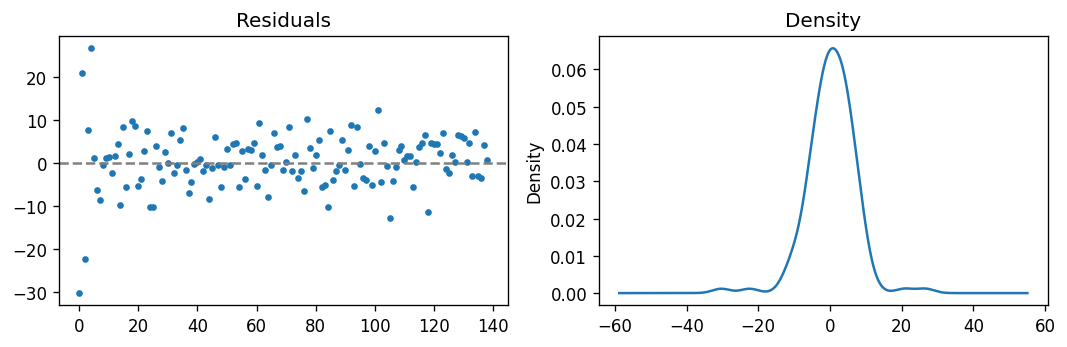

In [7]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], marker='.', linestyle='')
ax[0].axhline(y=0, color='grey', linestyle='--')
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.tight_layout()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
plt.show()

**Plotting the forecasts of our ARIMA model against the actual data**

Figure grp plots the **actual GMSL data** (blue) from 1880 to 2019 and **predicted GMSL data** (red) from 1972 to 2019. It can be seen that the plot of our predicted GMSL values from 1972 to 2019 (red) follows the **same upward trend** as the plot of the actual GMSL values in the same period. Additionally, the plot of our predicted values are **positioned closely and similarly** to the plot of the actual values, which means the predicted values are **close to the actual values during these years**.

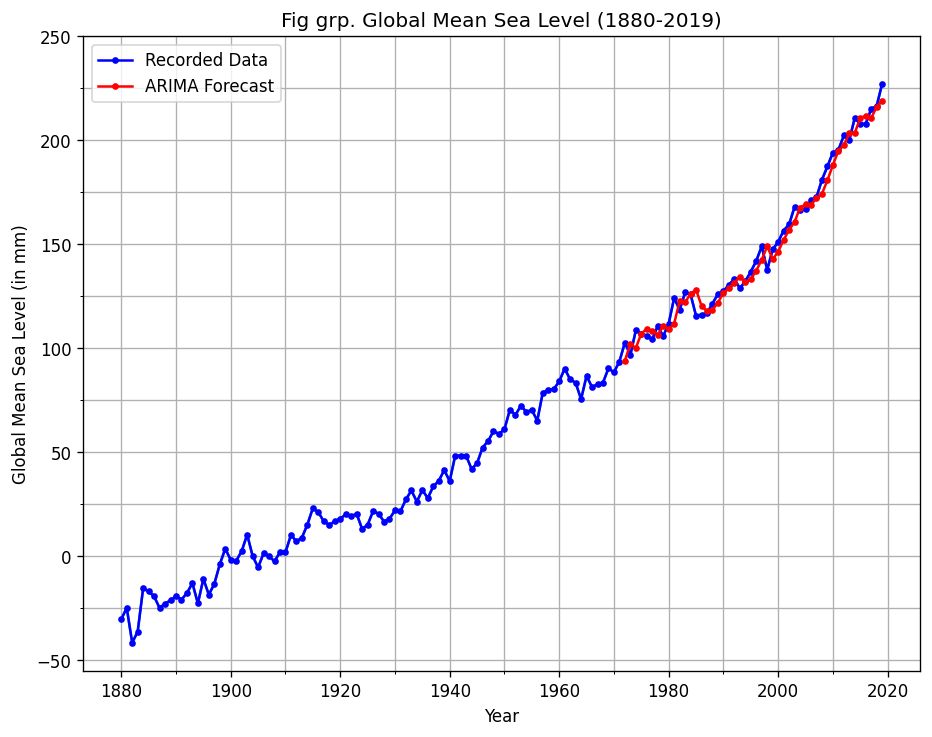

In [8]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, ax = plt.subplots()

ax.plot(df["sea_level"])

x = [i for i in range(1972, 2020)]
y = predictions
ax.plot(df["sea_level"], label='Recorded Data', color='blue', marker='.')
ax.plot(x, y, label='ARIMA Forecast', color='red', marker='.')
ax.set_yticks(np.arange(-50, 251, 25), minor=True)
ax.set_xticks(np.arange(1880, 2021, 10), minor=True)


# Labelling 

plt.xlabel("Year")
plt.ylabel("Global Mean Sea Level (in mm)")
plt.title("Fig grp. Global Mean Sea Level (1880-2019)")

# Display
plt.legend()
plt.grid(linestyle='-', which='both')
plt.show()


**Measuring the performance of our ARIMA model**

We measure the performance of our ARIMA model using the following metrics: Mean Absolute Percentage Error, and the Root Mean Square Error. The Mean Absolute Percentage Error of our ARIMA model is ~0.03135 or ~3.135% which means it is about 96.865% accurate in predicting the Global Mean Sea Level from 1972-2019. The Root Mean Square Error (which is also the standard deviation of the residuals) of our ARIMA model is ~5.308 which means that on average, the forecast of our ARIMA model would be ~5.308 units off.

In [9]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'rmse':rmse})

forecast_accuracy(np.array([[i] for i in predictions]), test)

{'mape': 0.03135399535366051, 'rmse': 5.308141383965546}

### CONCLUSION

Based on Fig grp which plots the **actual GMSL data** (blue) from 1880 to 2019 and the **predicted GMSL data** (red) from 1972 to 2019, it can be seen that the predicted GMSL values follow the same upward trend and are close to the actual GMSL values. Our ARIMA model obtained a Mean Absolute Percentage Error of ~3.135% and a Root Mean Square Error of ~5.308 which are indicative of good performance on our chosen dataset.

- This suggests that the parameters chosen for the ARIMA model (p, d, q) are very suitable for the particular dataset. This implies that the exploratory data analysis (EDA) procedures conducted sufficiently revealed the prominent qualities and patterns in our dataset, which led to suitable ARIMA parameters.
- Given the trends shown by our predictions, we can confidently assume that the GMSL values will continue to increase in the coming years.
- With this in mind, without interventions to mitigate climate change, the increasing global mean sea level will harm more coastal human residences and coastal animal habitats.

